# Suppliment: Why Perceptually-Uniform Colormaps are important

See Also:

- https://predictablynoisy.com/makeitpop-intro
- https://bids.github.io/colormap/

In [1]:
# Imports
import makeitpop

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
from metpy.interpolate import cross_section, log_interpolate_1d
import warnings

from scipy.interpolate import interp1d
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

In [2]:
# Setup the colormap (CVD-friendly Homeyer Rainbow from PyART)
def yuv_rainbow_24(nc):
    path1 = np.linspace(0.8*np.pi, 1.8*np.pi, nc)
    path2 = np.linspace(-0.33*np.pi, 0.33*np.pi, nc)

    y = np.concatenate([np.linspace(0.3, 0.85, nc*2//5),
                        np.linspace(0.9, 0.0, nc - nc*2//5)])
    u = 0.40*np.sin(path1)
    v = 0.55*np.sin(path2) + 0.1

    rgb_from_yuv = np.array([[1, 0, 1.13983],
                             [1, -0.39465, -0.58060],
                             [1, 2.03211, 0]])
    cmap_dict = {'blue': [], 'green': [], 'red': []}
    for i in range(len(y)):
        yuv = np.array([y[i], u[i], v[i]])
        rgb = rgb_from_yuv.dot(yuv)
        red_tuple = (i/(len(y)-1), rgb[0], rgb[0])
        green_tuple = (i/(len(y)-1), rgb[1], rgb[1])
        blue_tuple = (i/(len(y)-1), rgb[2], rgb[2])
        cmap_dict['blue'].append(blue_tuple)
        cmap_dict['red'].append(red_tuple)
        cmap_dict['green'].append(green_tuple)

    return cmap_dict

cmap = colors.LinearSegmentedColormap('homeyer_rainbow', yuv_rainbow_24(15), mpl.rcParams['image.lut'])

In [3]:
derivatives, derivatives_scaled = makeitpop.update_derivatives([cmap])

In [4]:
# Pull out the altered functions from the `makeitpop` library, so that they can
# work with our custom colormap
def popit(data, colormap='any', scaling_factor=20, invert=False):
    """Make your data pop!
    Non-linearly scaled a dataset according to the perceptual warping that
    is performed by a colormap. NOTE: YOU SHOULD NEVER DO THIS IN REAL LIFE.
    This is simply an attempt to illustrate more clearly what happens when 2-D
    data is visualized with colormaps that don't have a constant perceptual delta
    across values. For more information, see https://bids.github.io/colormap/
    Inputs
    ------
    data : numpy array
        The data you'd like to make more sexy.
    colormap : string | array, shape (n_derivatives,)
        The colormap you'd like to use to warp your data. If a string, this will
        index into `makeitpop.scaled_derivatives`. If an array, it is assumed to
        be the scaled derivatives of a colormap, where the first value corresponds
        to x == 0, and the last value to x == 1.
    scaling_factor : int
        Higher values will accentuate the "popping" effect.
    invert : bool
        Whether to invert the perceptual warping function of the colormap.
    Returns
    -------
    data_new : numpy array, shape data.shape
        The input data after being altered according to the perceptual warping
        for the colormap of your choice!
    """
    if data.ndim == 1:
        data = data[:, None]

    # The popper will take 0-1 values and map them onto the colormap's delta function 0-1 values
    popper = pop_like(colormap, scaling_factor=scaling_factor, invert=invert)

    # Scale so that we're between 0 and 1
    scaler = MinMax()
    data_norm = scaler.fit_transform(data)

    # Warp this CDF onto the one for the colormap we're using to pop
    data_norm_popped = popper(data_norm)

    # Create sexier data
    data_new = scaler.inverse_transform(data_norm_popped)
    data_new = data_new.reshape(data.shape)
    return data_new.squeeze()


def pop_like(colormap, scaling_factor=20, invert=False):
    """
    Parameters
    ----------
    colormap : string
        The colormap into which we'd like to warp our data.
    Returns
    -------
    popper : function
        A function that maps 0 to 1 values onto the 0 to 1
        values of new_map.
    """
    # Figure out the "true" y values for linear x inputs
    x = np.linspace(0, 1, 256)
    y_true = x.copy()
    derivatives_true = y_true[1] - y_true[0]

    # Now warp the y-values so their derivatives that of our perceptual deltas
    derivatives_warp = derivatives_scaled.iloc[:, 0] * scaling_factor
    if invert is True:
        derivatives_warp = derivatives_warp * -1

    # This tells us how much the linear derivs should be changed to make them warped
    derivatives_warped_diffs = derivatives_warp * derivatives_true

    y_warped = y_true + derivatives_warped_diffs
    popper = interp1d(x, y_warped)
    return popper

class MinMax(object):
    def __init__(self):
        pass

    def fit_transform(self, values):
        self.min = values.min()
        self.max = values.max()
        scaled = (values - self.min) / (self.max - self.min)
        return scaled

    def inverse_transform(self, values):
        if self.min is None:
            raise ValueError("You need to fit first!")
        return (values * (self.max - self.min)) + self.min

In [5]:
# Access data sample
refl = xr.open_dataset('/home/jon/dev/metpy_cross_section_ams_2019/notebooks/wrf_for_metpy_demo.nc').metpy.parse_cf()

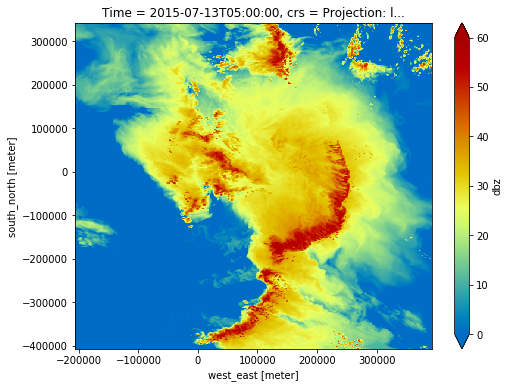

In [7]:
# Let's take a quick look at the composite reflectivity
max_refl = refl['dbz'].max(refl['dbz'].metpy.vertical.name)
max_refl[50:800, 400:1000].plot(cmap=cmap, vmin=0, vmax=60, figsize=(8,6.), aspect='equal')

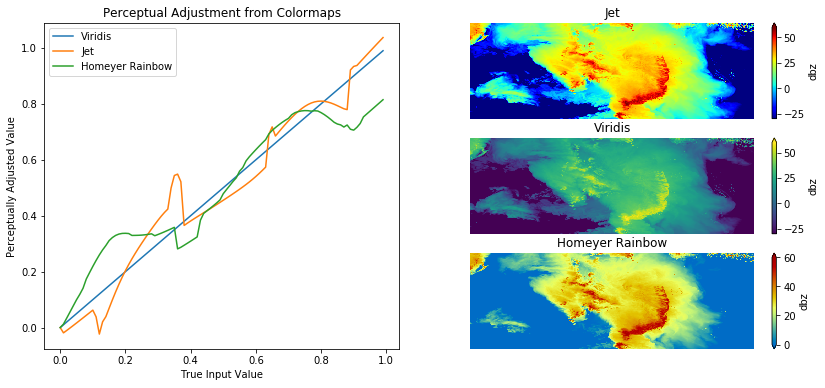

In [8]:
# Create the figure
fig = plt.figure(figsize=(14., 6.))
gs = gridspec.GridSpec(3, 2)

# Adjust ratios
data = np.arange(0, 1, .01)
data_jet = makeitpop.makeitpop(data, colormap='jet', scaling_factor=50)
data_hom = popit(data, scaling_factor = 50)

# Adjustment plot
ax = fig.add_subplot(gs[:, 0])
ax.plot(data, data, label="Viridis")
ax.plot(data, data_jet, label="Jet")
ax.plot(data, data_hom, label='Homeyer Rainbow')
ax.set_xlabel('True Input Value')
ax.set_ylabel('Perceptually Adjusted Value')
ax.set_title('Perceptual Adjustment from Colormaps')
ax.legend()

# Jet reflectivity plot
ax1 = fig.add_subplot(gs[0, 1])
max_refl[200:700, 300:1100].plot(ax=ax1, cmap='jet', vmin=-30, vmax=60)
ax1.axis('off')
ax1.set_title('Jet')

# Viridis reflectivity plot
ax2 = fig.add_subplot(gs[1, 1])
max_refl[200:700, 300:1100].plot(ax=ax2, cmap='viridis', vmin=-30, vmax=60)
ax2.axis('off')
ax2.set_title('Viridis')

# Homeyer Rainbow reflectivity plot
ax3 = fig.add_subplot(gs[2, 1])
max_refl[200:700, 300:1100].plot(ax=ax3, cmap=cmap, vmin=0, vmax=60)
ax3.axis('off')
ax3.set_title('Homeyer Rainbow')

# Save to poster directory
plt.savefig('../poster/figures/colormap_demo.png', dpi=600, bbox_inches='tight')